In [158]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime as dt

from sklearn import preprocessing
from sklearn import utils
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

csv_data = pd.read_csv("C:/Users/Asus/Anime.csv")

In [159]:
csv_data.dropna(subset=['Score'], inplace=True)
csv_data.drop_duplicates()

newdf = pd.DataFrame(csv_data)
newdf["English"].fillna("Unknown", inplace=True)
for index, row in newdf.iterrows():
    # If the value in the "English" column is "Unknown"
    if row["English"] == "Unknown":
        # Fill in missing data from "Title" to "English"
        newdf.loc[index, "English"] = row["Title"]

newdf = csv_data
# 1.extract only the day of broadcast
newdf['Day'] = newdf['Broadcast'].apply(lambda x: x.split(' ')[0])
# 2. extract only the season of broadcast, ignore year
newdf['Season'] = newdf['Premiered'].apply(lambda x: x.split(' ')[0])
# 3. extract only the year of broadcast, ignore season, extract last 4 characters if value is not 'Unknown'
newdf["Start_Aired"] = pd.to_datetime(newdf["Start_Aired"], errors="coerce")
newdf["Year"] = newdf["Start_Aired"].dt.year

# 4. calculate total duration of each show
#Append Total Duration = Number of Episodes * Duration into the dataset.
results_list = []

for i, row in newdf.iterrows():
    result = (row['Episodes']) * row['Duration_Minutes']
    results_list.append(result)

newdf['Total duration'] = results_list

# 5. Calculate the ratio of Favourites vs Members for each show, round to 4dp
results_list = []

for i, row in newdf.iterrows():
    result = (row['Favorites']) / (row['Members'])
    #result = round(result, 4)
    results_list.append(result)

newdf['FMratio'] = results_list

# 6. remove anime with Status as not yet aired as they do not have a score
newdf = newdf[newdf["Status"].str.contains("Not yet aired") == False]
# 7. combine Themes and Genres to new column Themes_Genres
newdf["Themes_Genres"] = newdf["Themes"] + ", " + newdf["Genres"]
# 8. delete irrelevant columns
newdf = newdf.drop(["Premiered", "Broadcast", "Genres", "Themes", "Episodes", "Duration_Minutes", \
                    "Title", "ID","Japanese","Synonyms","Synopsis", "Day", "Licensors",\
                    "Start_Aired","End_Aired", "Ranked", "Year", "Total duration"], axis=1)

num_predictors = ['Popularity', 'FMratio', 'Scored_Users', 'Score']

newdf = newdf.drop(newdf[newdf['Producers'] == 'Unknown'].index)

newdf.infer_objects()

,English,Type,Status,Producers,Studios,Source,Demographics,Rating,Score,Scored_Users,Popularity,Members,Favorites,Season,FMratio,Themes_Genres
0,Attack on Titan,TV,Finished Airing,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,Shounen,R - 17+ (violence & profanity),8.531,519803.0,1,3524109,155695,Spring,0.044180,"Gore, Military, Survival, Action, Drama"
1,Death Note,TV,Finished Airing,"VAP, Konami, Ashi Productions, Nippon Televisi...",Madhouse,Manga,Shounen,R - 17+ (violence & profanity),8.621,485487.0,2,3504535,159701,Fall,0.045570,"Psychological, Supernatural, Suspense"
2,Fullmetal Alchemist Brotherhood,TV,Finished Airing,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,Shounen,R - 17+ (violence & profanity),9.131,900398.0,3,2978455,207772,Spring,0.069758,"Military, Action, Adventure, Drama, Fantasy"
3,One Punch Man,TV,Finished Airing,"TV Tokyo, Bandai Visual, Lantis, Asatsu DK, Ba...",Madhouse,Web manga,Seinen,R - 17+ (violence & profanity),8.511,19066.0,4,2879907,59651,Fall,0.020713,"Parody, Super Power, Action, Comedy"
4,Sword Art Online,TV,Finished Airing,"Aniplex, Genco, DAX Production, ASCII Media Wo...",A-1 Pictures,Light novel,Unknown,PG-13 - Teens 13 or older,7.201,990254.0,5,2813565,64997,Summer,0.023101,"Love Polygon, Video Game, Action, Adventure, F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17542,Emerald no Oka,Music,Finished Airing,Avex Entertainment,Unknown,Original,Unknown,G - All Ages,5.791,114.0,17567,199,0,Unknown,0.000000,"Music, Drama"
17551,Arui Tekoteko,Music,Finished Airing,NHK,Unknown,Original,Kids,G - All Ages,5.141,108.0,17576,198,0,Unknown,0.000000,"Music, Unknown"
17630,Yamanai Ame,Music,Finished Airing,INoNaKa Music,Unknown,Original,Unknown,PG-13 - Teens 13 or older,5.991,111.0,17655,194,0,Unknown,0.000000,"Idols (Female), Music, Unknown"
17652,Fukuro,Movie,Finished Airing,Konami,Unknown,Game,Unknown,R+ - Mild Nudity,5.081,103.0,17677,192,0,Unknown,0.000000,"Psychological, Video Game, Horror, Suspense"


## Studios

In [160]:
from collections import defaultdict

# initialize a defaultdict to keep track of unique studios and their corresponding scores
unique_studios = defaultdict(lambda: {'count': 0, 'score': []})

# iterate through each row in the dataframe
for index, row in newdf.iterrows():
    # split the studios by comma and iterate through each studio
    for studio in row['Studios'].split(', '):
        # increment the count and add the score to the list for this studio
        unique_studios[studio]['count'] += 1
        #unique_studios[studio]['score'].append(row['Score'])
            
# create a new dataframe with the unique studios, count and average score using pd.concat
studio_df = pd.concat([pd.DataFrame({'Unique_Studios': studio, 'Count': values['count']}, index=[0]) for studio, values in unique_studios.items()], ignore_index=True)

print(studio_df)

       Unique_Studios  Count
0          Wit Studio     42
1            Madhouse    275
2               Bones    100
3        A-1 Pictures    169
4             Pierrot    144
..                ...    ...
692        Speed Inc.      1
693            Echoes      2
694   Saigo no Shudan      1
695        Suspenders      1
696  Composition Inc.      1

[697 rows x 2 columns]


In [139]:
# creating a new dataframe that holds all genres for each movie
studios_df = newdf['Studios'].str.split(", ", expand=True)

# stacking genres dataframe 
studios_df = studios_df.stack()

# configuring it as pandas dataframe
studios_df = pd.DataFrame(studios_df)

#Renaming the genres column and confirming value count
studios_df.rename(columns={0:'studios_stack'}, inplace=True)
studios_df.studios_stack.value_counts()

newdf.astype({'Studios': 'string'}).dtypes

# split the strings into lists

newdf['Studios'] = newdf['Studios'].str.split(', ')

newdf = newdf.explode(['Studios']).reset_index(drop=True)
newdf.head()

,English,Type,Status,Producers,Studios,Source,Demographics,Rating,Score,Scored_Users,Popularity,Members,Favorites,Season,FMratio,Themes_Genres
0,Attack on Titan,TV,Finished Airing,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,Shounen,R - 17+ (violence & profanity),8.531,519803.0,1,3524109,155695,Spring,0.044180,"Gore, Military, Survival, Action, Drama"
1,Death Note,TV,Finished Airing,"VAP, Konami, Ashi Productions, Nippon Televisi...",Madhouse,Manga,Shounen,R - 17+ (violence & profanity),8.621,485487.0,2,3504535,159701,Fall,0.045570,"Psychological, Supernatural, Suspense"
2,Fullmetal Alchemist Brotherhood,TV,Finished Airing,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,Shounen,R - 17+ (violence & profanity),9.131,900398.0,3,2978455,207772,Spring,0.069758,"Military, Action, Adventure, Drama, Fantasy"
3,One Punch Man,TV,Finished Airing,"TV Tokyo, Bandai Visual, Lantis, Asatsu DK, Ba...",Madhouse,Web manga,Seinen,R - 17+ (violence & profanity),8.511,19066.0,4,2879907,59651,Fall,0.020713,"Parody, Super Power, Action, Comedy"
4,Sword Art Online,TV,Finished Airing,"Aniplex, Genco, DAX Production, ASCII Media Wo...",A-1 Pictures,Light novel,Unknown,PG-13 - Teens 13 or older,7.201,990254.0,5,2813565,64997,Summer,0.023101,"Love Polygon, Video Game, Action, Adventure, F..."


In [161]:
# Convert studio_df dataframe to dictionary
studio_dict = studio_df.set_index('Unique_Studios')['Count'].to_dict()

# Print the resulting dictionary
print(studio_dict)

{'Wit Studio': 42, 'Madhouse': 275, 'Bones': 100, 'A-1 Pictures': 169, 'Pierrot': 144, 'ufotable': 43, 'CoMix Wave Films': 9, 'White Fox': 33, 'Sunrise': 280, 'Kyoto Animation': 83, 'J.C.Staff': 258, 'MAPPA': 51, 'Toei Animation': 257, 'P.A. Works': 43, 'asread.': 18, 'Lerche': 37, 'Production I.G': 219, 'Studio Deen': 210, 'CloverWorks': 34, 'Studio Ghibli': 19, 'Satelight': 77, 'Gainax': 44, 'Tatsunoko Production': 79, 'Trigger': 23, 'TMS Entertainment': 150, 'David Production': 35, 'Arms': 81, 'Kinema Citrus': 38, "Brain's Base": 74, 'Shaft': 82, 'TNK': 43, '8bit': 37, 'Manglobe': 21, 'Tezuka Productions': 32, 'Pierrot Plus': 20, 'LIDENFILMS': 58, 'Studio Bind': 3, 'Science SARU': 12, 'feel.': 54, 'Egg Firm': 2, 'AIC PLUS+': 13, 'Bridge': 17, 'Orange': 15, 'Doga Kobo': 58, 'SILVER LINK.': 76, 'Nexus': 7, 'Graphinica': 15, 'Nut': 6, 'Studio VOLN': 7, 'Telecom Animation Film': 31, 'Seven Arcs Pictures': 18, 'Artland': 33, 'AIC Build': 8, 'Imagin': 10, 'Tokyo Movie Shinsha': 36, 'Studi

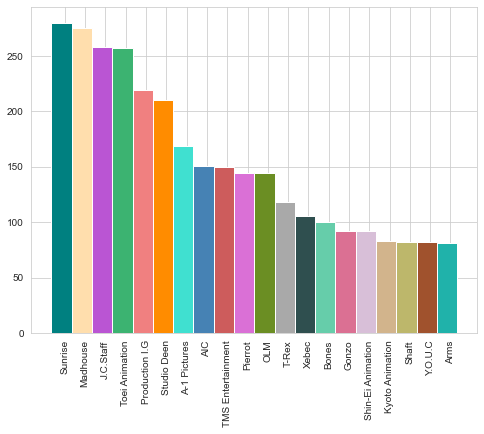

In [162]:
#HIST PLOT FOR TOP 20 STUDIOS

# sort studio_dict by values in descending order, and take the top 20 items
top_studios = dict(sorted(studio_dict.items(), key=lambda item: item[1], reverse=True)[1:21])

fig = plt.figure(figsize=(8,6)) #sets a different size (inches wide, inches tall)
ax = plt.subplot(111)
c = ['teal', 'navajowhite', 'mediumorchid', 'mediumseagreen', 'lightcoral','darkorange', 'turquoise', 'steelblue',
     'indianred', 'orchid','olivedrab', 'darkgrey', 'darkslategray', 'mediumaquamarine',
     'palevioletred', 'thistle', 'tan','darkkhaki', 'sienna', 'lightseagreen']

width=2.0
ax.bar(range(0,len(top_studios.keys())), top_studios.values(), width=width/2, color = c)
ax.set_xticks(np.arange(0,len(top_studios.keys())) + width/12)
ax.set_xticklabels(top_studios.keys())

locs, labels = plt.xticks() #gets labels
plt.setp(labels, rotation=90) #sets rotation of the labels

plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_65248\1997372358.py:6: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks([])


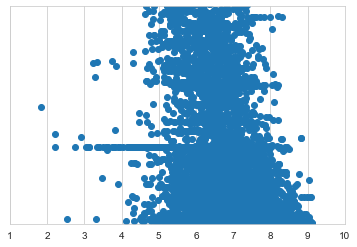

In [163]:
#SCATTER PLOT BEFORE KMEANS CLUSTERING

plt.scatter(newdf['Score'],newdf['Studios'])
plt.xlim(1,10)
plt.ylim(0, 700)
plt.yticks([])
plt.show()

In [164]:
#LABEL ENCODING STUDIOS COLUMN VALUES TO BECOME MULTICLASS FOR KMEANS ANALYSIS
lab_enc = preprocessing.LabelEncoder()
studios_encoded = lab_enc.fit_transform(newdf['Studios'])
print(studios_encoded)
print(utils.multiclass.type_of_target(studios_encoded))
print(utils.multiclass.type_of_target(studios_encoded.astype('int')))
print(utils.multiclass.type_of_target(studios_encoded))

[943 436 135 ... 927 927 927]
multiclass
multiclass
multiclass


In [170]:
#INITIALISE X AND Y

X = studios_encoded.reshape(-1,1)
y = newdf['Score']

print(X)

[[943]
 [436]
 [135]
 ...
 [927]
 [927]
 [927]]


Text(0.5, 1.0, 'Elbow Method For Optimal k')

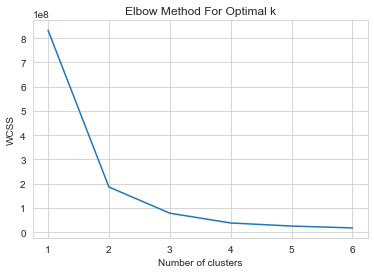

In [171]:
wcss=[]
for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(X)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')

In [182]:
kmeans = KMeans(3)
kmeans.fit(X)

identified_clusters = kmeans.fit_predict(X)
identified_clusters

array([0, 2, 1, ..., 0, 0, 0])

C:\Users\Asus\AppData\Local\Temp\ipykernel_65248\3820485789.py:4: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks([])


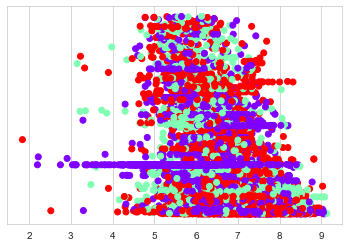

In [183]:
data_with_clusters = newdf.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(newdf['Score'],newdf['Studios'],c=data_with_clusters['Clusters'],cmap='rainbow')
plt.yticks([])
plt.show()

In [184]:
newdf.insert(0, "Cluster", identified_clusters, True)

In [185]:
#ILLUSTRATING NEW DATAFRAME

newdf.head()

# SPLITTING INDIVIDUAL CLUSTERS WITH ANALYSIS
#CREATING CLUSTER 0 DATAFRAME WITH CLUSTER 0 VALUES

Cluster0DF = newdf.query('Cluster == 0')
Cluster0DF.describe()

,Cluster,Cluster,Score,Scored_Users,Popularity,Members,Favorites,FMratio
count,4057.0,4057.0,4057.000000,4057.000000,4057.000000,4.057000e+03,4057.000000,4057.000000
mean,0.0,0.0,6.367448,23421.553858,8109.620902,5.116002e+04,693.338920,0.003192
std,0.0,0.0,0.921514,79662.093205,4618.419174,1.830108e+05,5995.982356,0.004998
min,0.0,0.0,2.201000,102.000000,1.000000,1.790000e+02,0.000000,0.000000
25%,0.0,0.0,5.701000,338.000000,4266.000000,1.022000e+03,1.000000,0.000591
50%,0.0,0.0,6.341000,1479.000000,8129.000000,4.131000e+03,7.000000,0.001783
75%,0.0,0.0,7.041000,8230.000000,11864.000000,2.025000e+04,57.000000,0.003760
max,0.0,0.0,9.081000,910653.000000,17883.000000,3.524109e+06,177620.000000,0.090290


In [176]:
#CLUSTER 1 STATISTICS

Cluster1DF = newdf.query('Cluster == 1')
Cluster1DF.describe()

,Cluster,Score,Scored_Users,Popularity,Members,Favorites,FMratio
count,2823.0,2823.000000,2823.000000,2823.000000,2.823000e+03,2823.000000,2823.000000
mean,1.0,6.804989,52795.967056,5151.929153,1.139744e+05,1439.941552,0.004247
std,0.0,0.846366,120327.013172,3744.135694,2.640207e+05,7437.597556,0.005873
min,1.0,1.841000,105.000000,2.000000,2.110000e+02,0.000000,0.000000
25%,1.0,6.241000,1559.000000,1825.000000,4.301000e+03,7.000000,0.001084
50%,1.0,6.831000,6533.000000,4630.000000,1.698500e+04,36.000000,0.002346
75%,1.0,7.371000,42204.500000,8023.500000,9.763400e+04,313.000000,0.005028
max,1.0,9.041000,997243.000000,17336.000000,3.504535e+06,188649.000000,0.076557


In [177]:
#CLUSTER 2 STATISTICS

Cluster2DF = newdf.query('Cluster == 2')
Cluster2DF.describe()

,Cluster,Score,Scored_Users,Popularity,Members,Favorites,FMratio
count,2069.0,2069.000000,2069.000000,2069.000000,2.069000e+03,2069.000000,2069.000000
mean,2.0,6.698274,52348.922668,5005.201547,1.129312e+05,1339.483325,0.003979
std,0.0,0.847617,121668.634490,3714.323668,2.642634e+05,7235.164828,0.005502
min,2.0,3.151000,105.000000,3.000000,2.040000e+02,0.000000,0.000000
25%,2.0,6.131000,1568.000000,1812.000000,4.591000e+03,7.000000,0.001129
50%,2.0,6.681000,7988.000000,4199.000000,2.107500e+04,40.000000,0.002198
75%,2.0,7.291000,41892.000000,7828.000000,9.872800e+04,326.000000,0.004597
max,2.0,9.131000,990254.000000,17475.000000,2.978455e+06,207772.000000,0.069758


<AxesSubplot:xlabel='Cluster', ylabel='Score'>

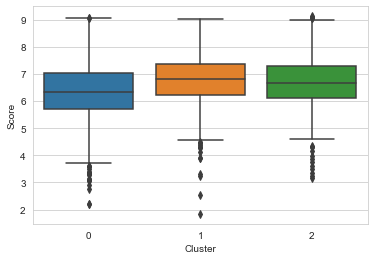

In [178]:
#COMBINED BOXPLOT OF THE 3 CLUSTERS

sb.set_style("whitegrid")
  
sb.boxplot(x = 'Cluster', y = 'Score', data = newdf)

For n_clusters = 3 The average silhouette_score is : 0.638936642824506


IndexError: index 1 is out of bounds for axis 1 with size 1

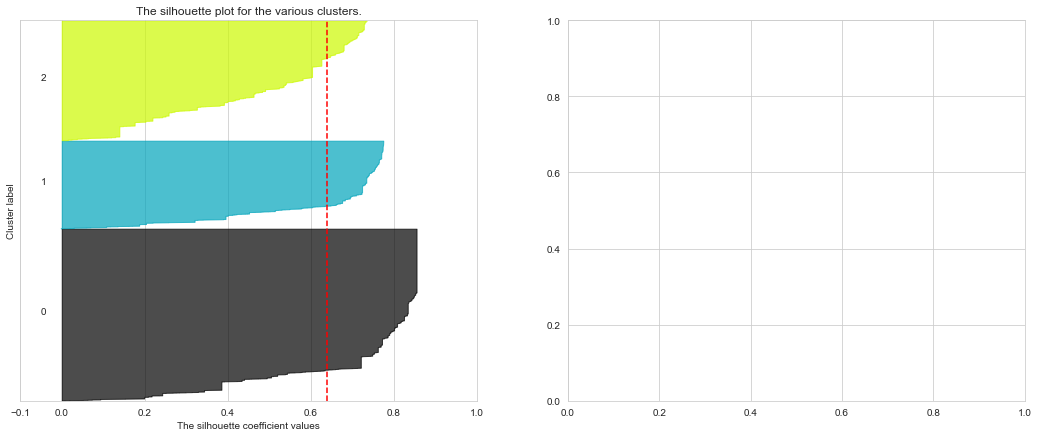

In [179]:
range_n_clusters = [3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter( X[:, 0], X[:, 1],
        marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14)